In [18]:
import numpy as np
from pymanopt.manifolds import Sphere
import matplotlib.pyplot as plt
import mala.potentials
import mala.metropolis_hastings as mh
import mala.icosehedron as ico
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx

%matplotlib notebook

%load_ext autoreload
%autoreload 2

phi = (1 + 5 ** 0.5) / 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# A crash-course on how the icosahedron is currently implemented

# Generate vertices via G 

We have two generators, a permutation $(x,y,z)\rightarrow(z,x,y)$ and a negation $(x,y,z)\rightarrow(-x,y,z)$

$$G_1 = \begin{bmatrix}
0 & 0 & 1\\
1 & 0 & 0\\
0 & 1 & 0
\end{bmatrix},\qquad
G_2 = \begin{bmatrix}
-1 & 0 & 0\\
0 & 1 & 0\\
0 & 0 & 1
\end{bmatrix}$$

We can pick any arbitrary vertex of the icosehedron (e.g. $v_0 = (1,\phi,0)$) and its orbit under G will generate all the icosehedron vertices. We name the vertices by the group elements that generated them (this naming isn't unique: two elements of the group generate any $v_1$ from $v_0$, but we'll just stick to one of the two wolg).

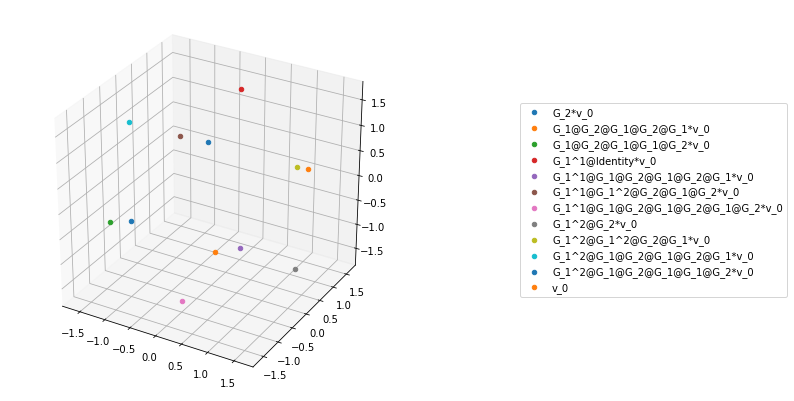

In [16]:
G = ico.generate_G(verbose=False)
V = ico.generate_V(G)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

for idx,v in enumerate(V):
    ax.scatter(v.p[0],v.p[1],v.p[2],label=v.name)
    
plt.legend(loc='right', bbox_to_anchor=(1, 0., 1, 1))
plt.show()

# Transforming between chart coordinates and Euclidean coordinates

We need methods for projecting points on the sphere down into the $\mathbb{R}^2$ plane of the face and vice versa.

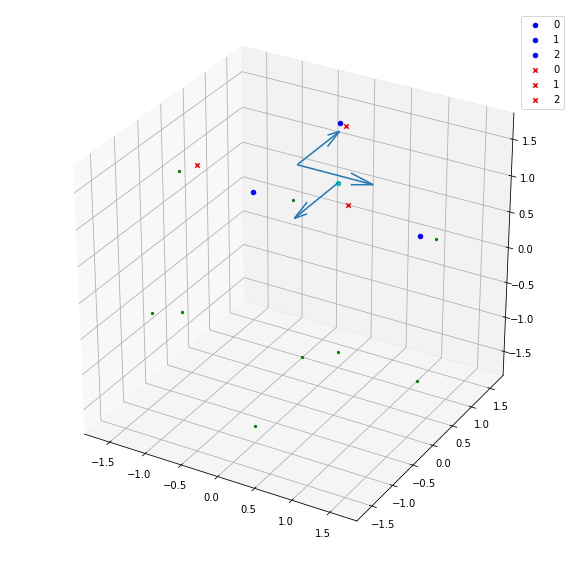

In [5]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

for idx,v in enumerate(V):
    ax.scatter(v.p[0],v.p[1],v.p[2],marker='.',color='g')
    
top_face = ico.ambient_face(V[3],V[5],V[8])

R = ico.chart_transformation(top_face)

f_0 = top_face.return_coors()
centered_f = [np.matmul(R,v) for v in f_0]

face_list = [f_0,centered_f]
marker_list = ['o','x']
color_list = ['b','r']
for f_idx,f in enumerate(face_list):
    for v_idx,p in enumerate(f):
        ax.scatter(p[0],p[1],p[2],marker=marker_list[f_idx],
                   color=color_list[f_idx],
                   label=str(v_idx))
        
ax.scatter(top_face.ctd_coors[0],top_face.ctd_coors[1],top_face.ctd_coors[2],color='c')
ax.quiver(top_face.ctd_coors[0],top_face.ctd_coors[1],top_face.ctd_coors[2],
         top_face.basis_1[0],top_face.basis_1[1],top_face.basis_1[2])


c_prime = np.matmul(R,top_face.ctd_coors)

for v_prime in [np.matmul(R,top_face.basis_1),np.matmul(R,top_face.basis_2)]:
    ax.quiver(c_prime[0],c_prime[1],c_prime[2],
         v_prime[0],v_prime[1],v_prime[2])

plt.legend()
plt.show()

# Building face graph

Takes in a list of named vertices, assumed to correspond to the icosehedron. First builds a graph of labeled vertices, and then the dual graph, where each node corresponds to a face whose name is a tuple of vertex names

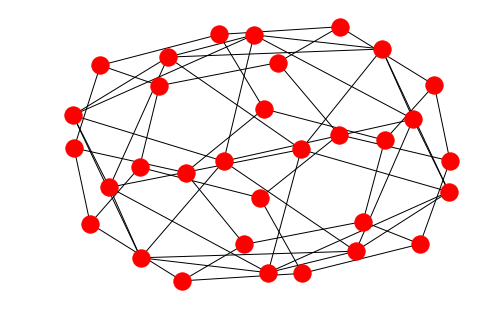

In [6]:
face_graph,vertex_graph = ico.build_face_graph(V,verify=True)
nx.draw(face_graph)
nx.draw(vertex_graph)

# face dict takes the names of nodes in our face graph and maps them to ambient_face objects,
# which contain geometric information about the face
face_dict = ico.build_face_map(face_graph,V)

<IPython.core.display.Javascript object>


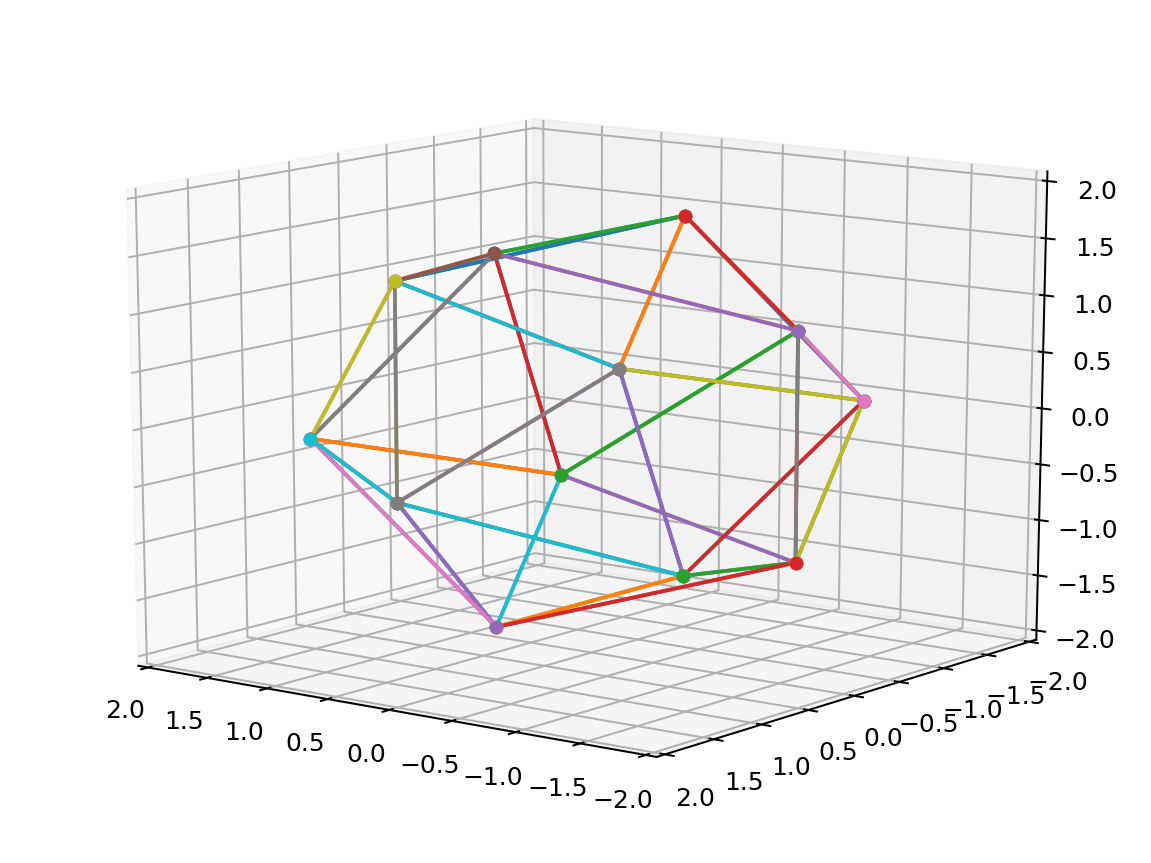

In [20]:
# Draw this monstrosity to make sure its doing what we want
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
fig = plt.figure()
ax = Axes3D(fig)
for face_node in list(face_graph.nodes()):
    u,v,w = face_dict[face_node].return_coors()
    for x,y in [[u,v],[v,w],[u,w]]:
        ax.plot([x[0],y[0]],[x[1],y[1]],[x[2],y[2]])
    for v in face_dict[face_node].return_coors():
        ax.scatter(v[0],v[1],v[2])
    
ax.axes.set_xlim3d(left=-2, right=2) 
ax.axes.set_ylim3d(bottom=-2, top=2) 
ax.axes.set_zlim3d(bottom=-2, top=2) 
plt.show()

#look, a pretty icosehedron

We want to be able to check whether the projection of a particular point (a) lies within the image of the chart of a face and/or (b) lies within the face $\textit{itself}$.

<IPython.core.display.Javascript object>


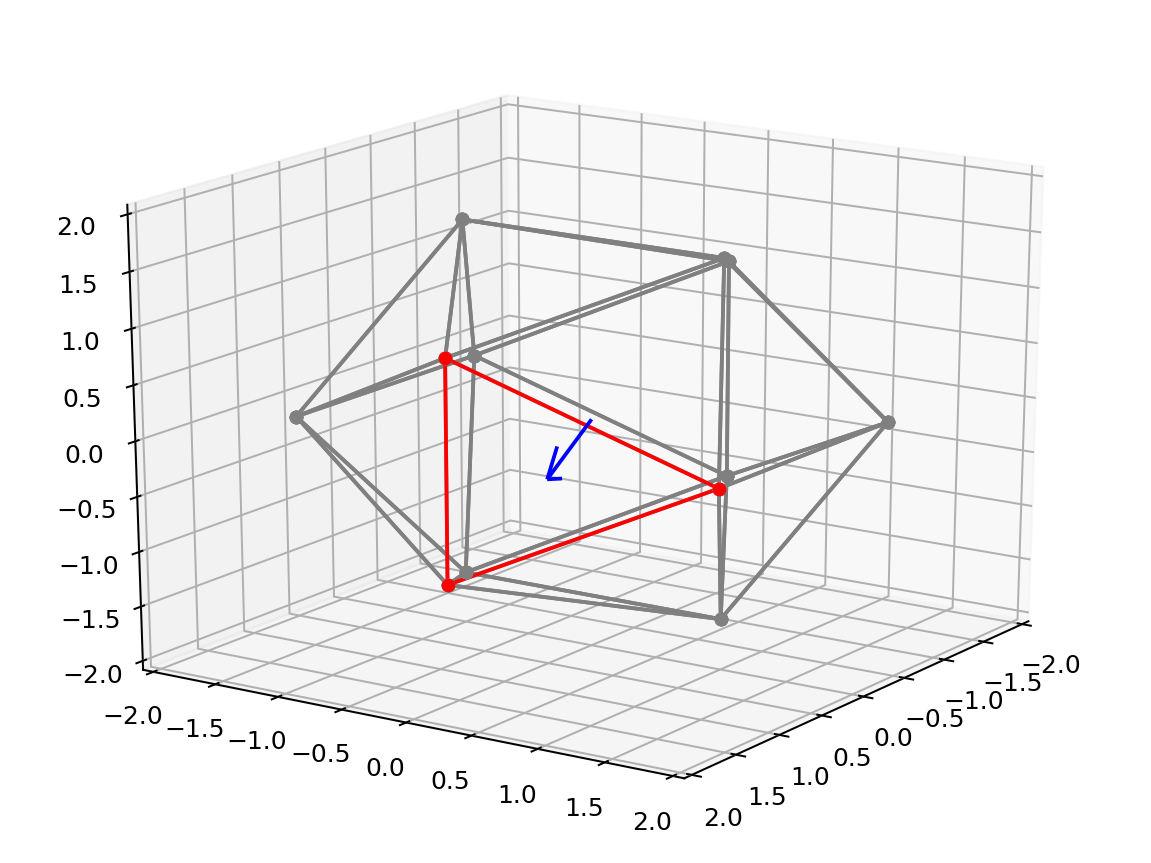

Is  [-1.09818547 -1.09818547 -1.09818547]  in this chart?  False
Is  [-1.09818547 -1.09818547 -1.09818547]  in this face?  False


<IPython.core.display.Javascript object>


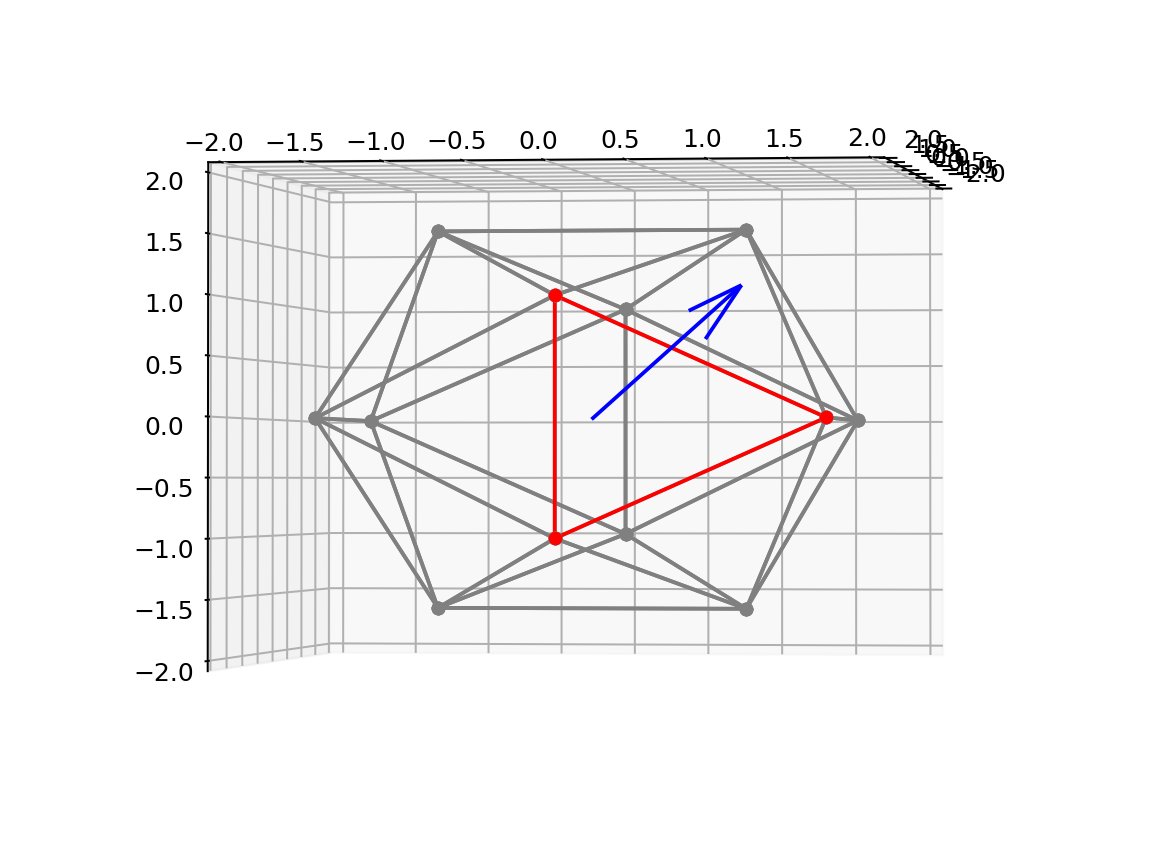

Is  [1.09818547 1.09818547 1.09818547]  in this chart?  True
Is  [1.09818547 1.09818547 1.09818547]  in this face?  False


<IPython.core.display.Javascript object>


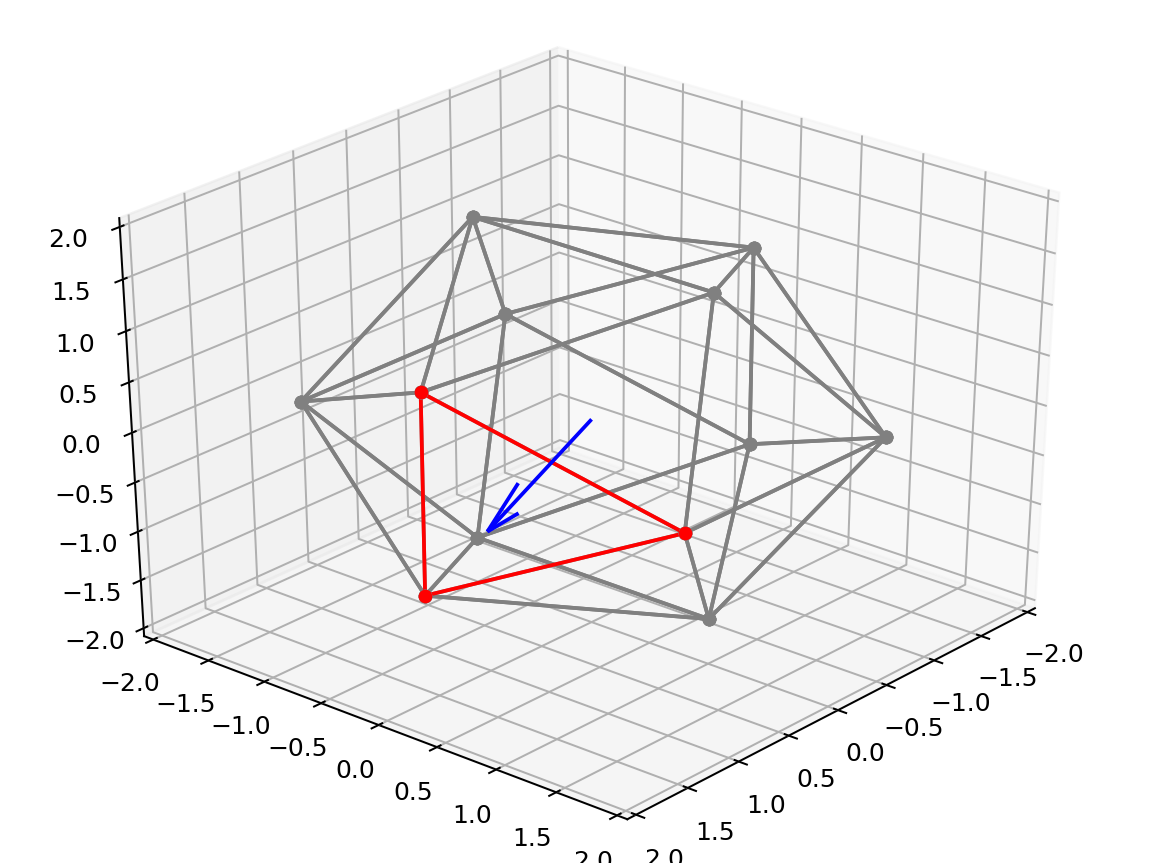

Is  [1.77690142 0.67871595 0.        ]  in this chart?  True
Is  [1.77690142 0.67871595 0.        ]  in this face?  True


In [19]:
target_idx = 19
target_face = face_dict[list(face_graph.nodes())[target_idx]]
point = -2*np.array([1,1,1])

sphere_radius = np.linalg.norm(target_face.v_1.p,ord=2)

for point in [-2*np.array([1,1,1]),np.array([1,1,1]),2*target_face.ctd_coors]:
    point = sphere_radius*np.divide(point,np.linalg.norm(point,ord=2))

    fig = plt.figure()
    ax = Axes3D(fig)
    for idx,face_node in enumerate(list(face_graph.nodes())):
        if idx==target_idx:
            plot_color = 'red'
        else:
            plot_color='grey'

        u,v,w = face_dict[face_node].return_coors()
        for x,y in [[u,v],[v,w],[u,w]]:
            ax.plot([x[0],y[0]],[x[1],y[1]],[x[2],y[2]],color=plot_color)
        for v in face_dict[face_node].return_coors():
            ax.scatter(v[0],v[1],v[2],color=plot_color)

    ax.quiver(0,0,0,point[0],point[1],point[2],color='b')

    ax.axes.set_xlim3d(left=-2, right=2) 
    ax.axes.set_ylim3d(bottom=-2, top=2) 
    ax.axes.set_zlim3d(bottom=-2, top=2) 
    plt.show()

    print('Is ',point,' in this chart? ',ico.check_if_point_in_chart(point,target_face))
    print('Is ',point,' in this face? ',np.all(ico.check_if_point_in_face(point,target_face)))

## If we've stepped over the edge of a face, we want to know which face we've stepped into

In [44]:
from itertools import compress

# pt is a numpy array of coordinates in the image of our origin face chart.
# given a point accross the edge of our face, ID which face it
# has crossed into and change its coordinates
def transition_charts(pt,origin_face,face_graph):
    # make sure we're in our chart, and have crossed an edge
    assert check_if_point_in_chart(pt,origin_face)
    assert check_if_point_in_chart(pt,origin_face)
    
    # determine which edge we've crossed
    side_crossings = [not inside_l for inside_l in check_if_point_in_face(pt,face)]
    
    # determine which face we're stepping into
    destination_face = face_across_edge(origin_face,side_crossings,face_graph)
    
    # change coordinates
    return map_pt_btwn_charts(pt,origin_face,dest_face)

# side_crossings is a list of booleans indicating whether we're crossing
# over l1, l2, or l3 (recall these correspond to the lines between 
# [ (x2,x3),(x1,x3),or (x1,x2)] respectively), as per conventions
# in "Isabelle's Icosahedron"
def face_across_edge(face,side_crossings,face_graph):
    # first, ID the edge we're traversing using a pair of vertices
    face_verts = (face.v_1.name,face.v_2.name,face.v_3.name)
    vertex_pairs = [(face_verts[1],face_verts[2]),(face_verts[0],face_verts[2]),
                    (face_verts[0],face_verts[1])]
    edge = list(compress(vertex_pairs,side_crossings))[0]
    
    # find a face that contains the same edge that isn't our og face
    edge_adjacent_face = [f for f in face_graph if len(set(edge) & set(f))==2 
                       and set(f)!=set(face_verts)]
    
    return edge_adjacent_face

# pt is a numpy array of coordinates in the image of our origin face chart.
def map_pt_btwn_charts(pt,origin_face,dest_face):
    # pt needs to be in the overlap of the face charts
    assert check_if_point_in_chart(pt,origin_face)
    assert check_if_point_in_chart(pt,dest_face)
    
    # first, get Euclidean coordinates of our point
    euc_pt = chart2euclidean(pt,origin_face)
    
    # next, move into coordinates of second chart
    return euclidean2chart(euc_pt,dest_face)
    

In [43]:
target_face = face_dict[list(face_graph.nodes())[0]]
print(list(face_graph.nodes())[0])

options = face_across_edge(target_face,[False,True,False],face_graph)

print(options)

('G_2*v_0', 'G_1^1@Identity*v_0', 'G_1^2@G_1@G_2@G_1@G_2@G_1*v_0')
[('G_2*v_0', 'G_1^2@G_1@G_2@G_1@G_2@G_1*v_0', 'G_1^2@G_1@G_2@G_1@G_1@G_2*v_0')]


In [47]:
[not g for g in  [False, True, False]]

[True, False, True]